<a href="https://colab.research.google.com/github/mrcasutt/lightinthedark/blob/master/light_the_dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
#mount google drive to save models directly to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import libraries used
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import matplotlib as plt
from imutils import paths
from google.colab import files
import argparse
import requests
import cv2
import os
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFile
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [4]:
#make RAdam availible
shutil.copy('/content/drive/My Drive/models/light/radam.py','/content/radam.py')

'/content/radam.py'

In [0]:
#install RAdam optimizer
from radam import *

In [0]:
#command to delete training folder in case of mistake during download and initialization  
shutil.rmtree('./downloads')

In [0]:
#set up paths and folders to download files
keyword = 'portrait'
folder = keyword
path = Path('./downloads')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
urlname = 'url.csv'
urlpath = Path('/content')
classes = ['train']

In [0]:
#urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
#window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [0]:
#download funktion to quickly download images generated from javascript insert above
download_images(urlpath/urlname, dest)

In [0]:
#fastai verify function to make sure images are readable
verify_images(dest, delete=True, max_size=2000);

In [0]:
#set up pathes used by resize and dataloader
path_orig = Path('./downloads/'+keyword)
path_hr = Path('./downloads/high_res')
path_mr = Path('./downloads/med_res')
path_lr = Path('./downloads/low_res')
model_path = Path('./downloads')
il = ImageList.from_folder(path_orig)



In [0]:
#resize function
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_orig)                               #ceate destination path
    dest.parent.mkdir(parents=True, exist_ok=True)                      #create desination folder
    img = PIL.Image.open(fn)                                            #open image form path
    img = img.convert('RGB')                                            #force RGB for all images
    targ_sz = resize_to(img, size, use_min=True)                        #initialize target size
    enhancer = ImageEnhance.Brightness(img)                             #initialize brightness function
    b = random.uniform(0.1,0.3)                                         #random generator for brightness values
    img = enhancer.enhance(b)                                           #apply random brightness
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)              #resize image
    w,h = img.size                                                      #initialize width and height for save
    q = random.randint(40,80)                                           #random generator for quality
    img.save(dest, quality=q)                                           #save image object in destination with random quality

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr,96),(path_mr,256),(path_hr,1200)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
#initialize batch size and size, model architecture and image names
bs,size = 64,96
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)


In [0]:
#function to get the data into a dataloader
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
#load data
data = get_data(bs,size)

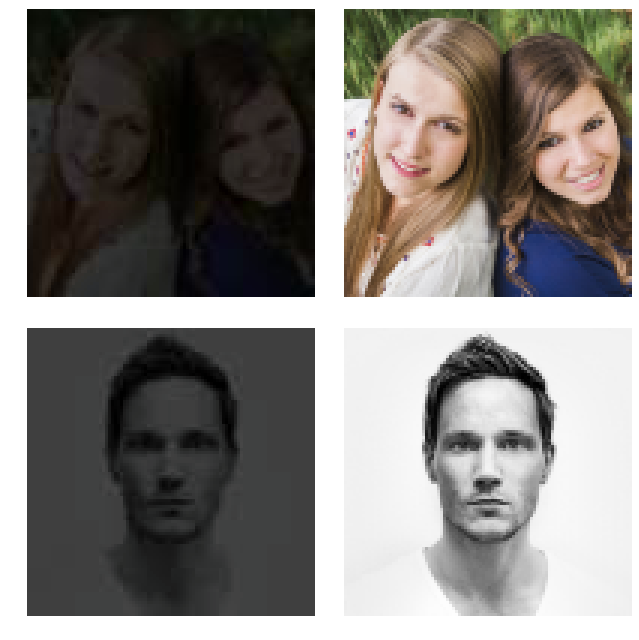

In [24]:
#show a couple of images 
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [25]:
#initialize vgg16 model (see fastai course v3/lesson 9 for details)
t = data.valid_ds[0][1].data
t = torch.stack([t,t])
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
#create feature loss class for training
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
#set up learner object
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
raoptar = partial(RAdam) #RAadam used as optimizer
wd = 1e-3
lr = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


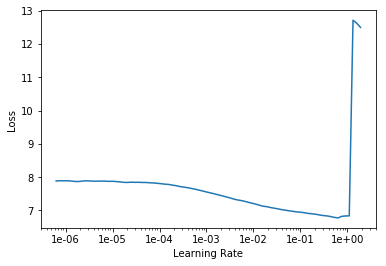

In [28]:
#find ideal learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
#create a do fit function that autosaves the result and displays some images after training
def do_fit(save_name, lrs=slice(lr), pct_start=0.1, cycles=20):
    learn.fit_one_cycle(cycles, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,7.871593,7.185057,1.265164,0.424277,0.537422,0.197308,1.836249,2.610854,0.313782,00:44
1,7.792933,7.198007,1.257090,0.429888,0.537085,0.197093,1.843966,2.619927,0.312959,00:40
2,7.650197,7.110805,1.247889,0.426719,0.540092,0.195422,1.786692,2.604359,0.309633,00:40
3,7.484942,6.999336,1.238534,0.420056,0.542209,0.193218,1.716515,2.581929,0.306874,00:40
4,7.331235,6.878789,1.222342,0.415271,0.540427,0.188531,1.674635,2.538201,0.299384,00:40
5,7.190133,6.771253,1.197790,0.410455,0.537017,0.184841,1.650427,2.497706,0.293018,00:40
6,7.069505,6.674932,1.170656,0.405679,0.533587,0.181046,1.630326,2.467281,0.286357,00:40
7,6.961181,6.583494,1.142921,0.402446,0.531663,0.177043,1.610351,2.439263,0.279806,00:41
8,6.851574,6.507567,1.119482,0.399402,0.530007,0.174141,1.593975,2.415003,0.275557,00:40
9,6.752909,6.442185,1.100534,0.398120,0.529031,0.171910,1.577798,2.392640,0.272154,00:39


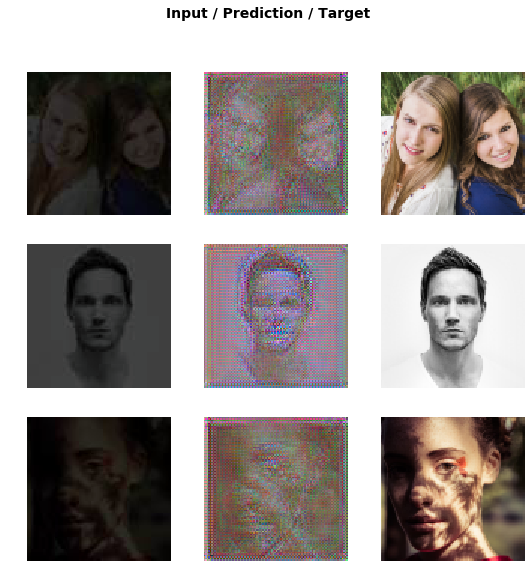

In [30]:
#first run training only the last layers on small images
do_fit('1a', slice(1e-4,1e-1))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


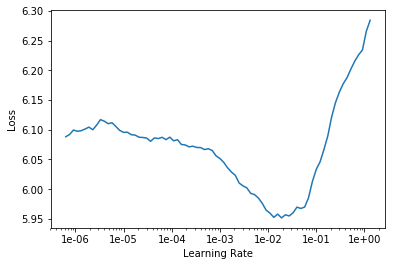

In [31]:
#unfreeze model and find new learning rates
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,6.104453,6.225656,1.024344,0.391295,0.527027,0.168827,1.517799,2.328085,0.268278,00:40
1,6.069999,6.126616,0.984305,0.388514,0.527517,0.167752,1.484014,2.306670,0.267844,00:39
2,5.969797,5.959801,0.890044,0.380829,0.524030,0.165227,1.448640,2.280392,0.270638,00:40
3,5.898952,5.794158,0.778720,0.371027,0.517273,0.164199,1.420265,2.270353,0.272321,00:40
4,5.783615,5.536273,0.672838,0.362659,0.507143,0.160200,1.344548,2.217339,0.271546,00:41
5,5.657699,5.451881,0.605622,0.361436,0.507422,0.161386,1.311356,2.231293,0.273365,00:41
6,5.548532,5.341719,0.615789,0.354489,0.495174,0.156970,1.269873,2.178397,0.271027,00:41
7,5.433558,5.275941,0.602582,0.349676,0.486076,0.154363,1.258711,2.152652,0.271882,00:40
8,5.343462,5.397995,0.646185,0.352516,0.490488,0.159788,1.286919,2.186309,0.275792,00:41
9,5.266141,5.088065,0.493460,0.344658,0.478761,0.153065,1.219171,2.130484,0.268467,00:41


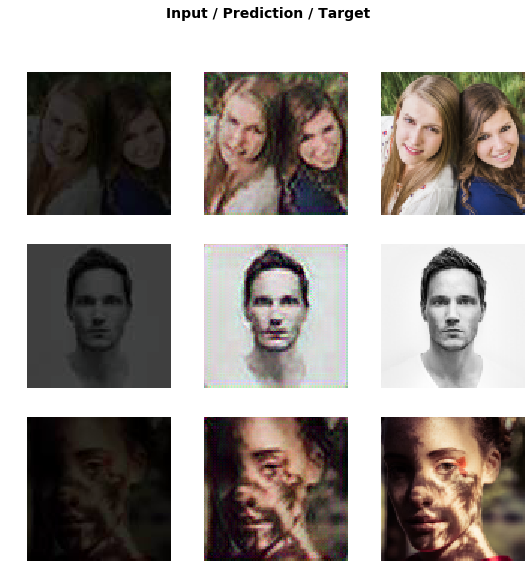

In [32]:
#second training run for whole model
do_fit('1b', slice(1e-3,1e-2),cycles=30)

In [0]:
#refreeze trained model
learn.freeze()

In [0]:
#initialize medium sized images as new dataset for training
size = 256
bs = 16
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
#load medium sized images
learn.data = data_mr

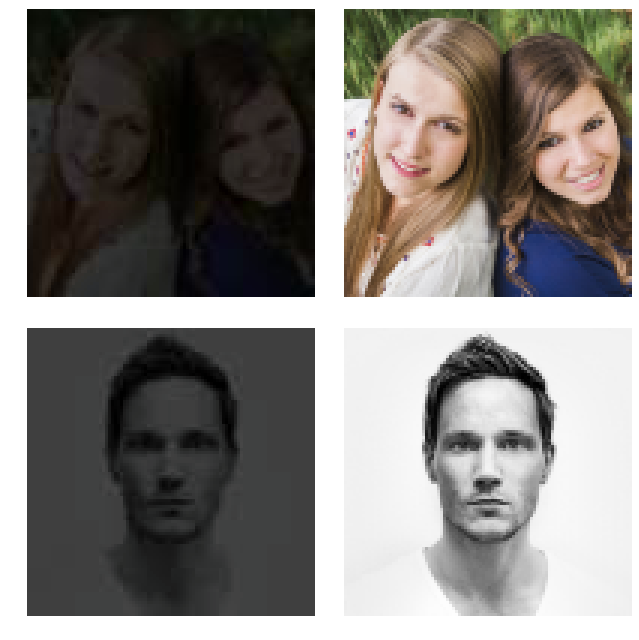

In [37]:
#show medium sized images
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [38]:
#free up some memory
gc.collect()

29670

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


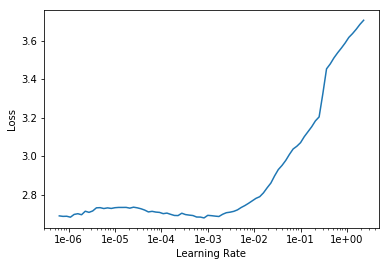

In [39]:
#find learning rates for last layers of larger images
learn.lr_find()
learn.recorder.plot()

In [0]:
#train last layers of model on medium images
do_fit('2a',slice(1e-4,1e-3),cycles=6)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.648420,2.734120,0.355686,0.276753,0.330355,0.092277,0.599823,0.970658,0.108567,01:44


In [59]:
#unfreeze whole model and free up some memory
learn.unfreeze()
gc.collect()

22038

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


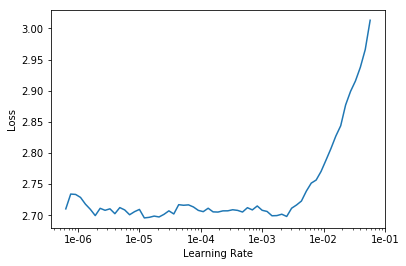

In [60]:
#find learning rates for whole model
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.720860,2.410627,0.340792,0.278018,0.318871,0.072231,0.581704,0.759406,0.059604,00:16
1,2.730348,2.409456,0.337486,0.278309,0.319300,0.072467,0.582284,0.759804,0.059807,00:16
2,2.715274,2.404422,0.333094,0.278629,0.319252,0.072740,0.582411,0.758310,0.059986,00:15
3,2.711415,2.405679,0.333108,0.278817,0.319262,0.072925,0.583492,0.757995,0.060080,00:15
4,2.701471,2.404574,0.333904,0.278408,0.319213,0.072599,0.581893,0.758687,0.059870,00:16
5,2.706379,2.404596,0.334145,0.278422,0.319192,0.072609,0.581681,0.758661,0.059885,00:15
6,2.706343,2.400058,0.330234,0.278674,0.319122,0.072835,0.581917,0.757246,0.060030,00:16
7,2.710315,2.404637,0.332451,0.278704,0.319176,0.072878,0.582997,0.758269,0.060162,00:16
8,2.707752,2.402422,0.330013,0.279085,0.319401,0.073090,0.583431,0.757331,0.060072,00:16
9,2.703104,2.402425,0.330827,0.278957,0.319303,0.072953,0.583001,0.757343,0.060041,00:15


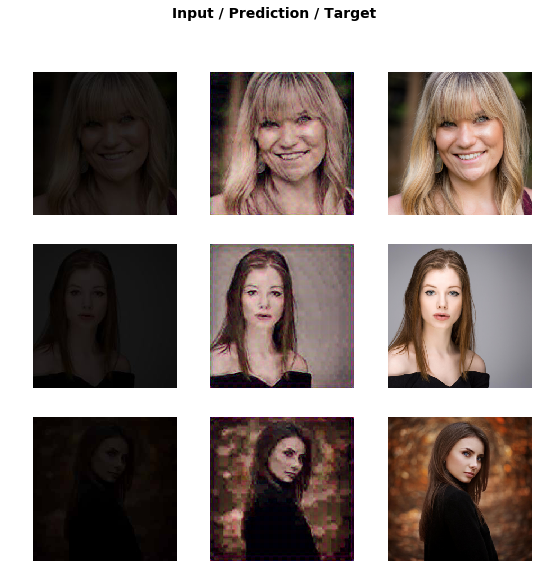

In [61]:
#fit whole model with medium sized images
do_fit('2b', slice(1e-5 ), pct_start=0.3,cycles=30)

In [132]:
#destroy learner
learn.destroy()


this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
#make sure learner is empty
learn = None

In [134]:
#free up cuda memory
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
class GradientAccumulator(LearnerCallback):
    """Accumulates gradients over N iterations
    Usage:
    accumulator = partial(GradientAccumulator, num_iterations=100)
    learn = create_cnn(data, models.resnet18, callback_fns = [accumulator])
    """
    def __init__(self, learn: Learner, num_iterations: int = 4, disable_callback: bool = False):
        """
        :param num_iterations: Accumulate gradients over `num_iterations` iterations before taking an optimizer step
        """
        super().__init__(learn)
        self.num_iterations = num_iterations
        self.skipped_last_backprop = False

    def on_backward_end(self, iteration, **kwargs) -> None:
        if (iteration % self.num_iterations != 0) or (iteration == 0):
            self.skipped_last_backprop = True
            return {'skip_step': True, 'skip_zero': True}
        else:
            self.skipped_last_backprop = False

    def on_step_end(self, **kwargs):
        if self.skipped_last_backprop:
            return {'skip_zero': True}

    def on_epoch_end(self, **kwargs) ->bool:
        """Deals with the edge case of an epoch ending"""
        if self.skipped_last_backprop:
            self.learn.opt.step()
            self.learn.opt.zero_grad()

In [0]:
accumulator = partial(GradientAccumulator, num_iterations=10)
callbacks = [LossMetrics,accumulator]

In [0]:
#recreate learner object 
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=callbacks,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)

In [0]:
#load model that was trained on medium sized images
learn.load('2b');

In [0]:
#initialize high res images and show some
#It's probably a good idea to implement gradient accumulation at this point (I'll need to figure out how to do that)
size = 664
bs=2
data_hr = (ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(max_zoom=2),size = size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_hr.c = 3
learn.data = data_hr
#data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [140]:
#empty memory
torch.cuda.empty_cache()
gc.collect()

70

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


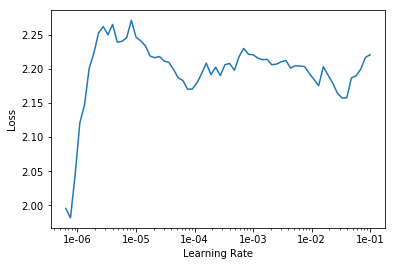

In [141]:
#find learning rates for last layer of high res data
learn.lr_find()
learn.recorder.plot()

In [142]:
do_fit('3a',slice(1e-7),cycles=20)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.193845,1.859075,0.410784,0.253356,0.249302,0.055538,0.492293,0.369822,0.027981,02:14
1,2.362291,2.643284,0.670335,0.270035,0.239793,0.072200,0.854703,0.492812,0.043406,02:02
2,300269.375000,399.639008,55.117882,1.719803,5.374666,0.213611,54.859989,281.905182,0.447817,02:00


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
learn.save(model_path/'light_model')

In [0]:
#unfreeze model
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


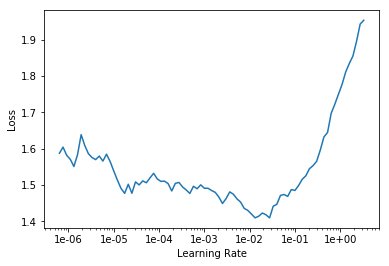

In [53]:
#find learning rates
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.487290,1.372970,0.373824,0.201826,0.194915,0.039032,0.315619,0.219250,0.028506,17:34
1,1.486619,1.363907,0.364275,0.202083,0.195145,0.039078,0.314810,0.220075,0.028442,17:35
2,1.464639,1.357889,0.357694,0.202370,0.195202,0.039111,0.314737,0.220401,0.028374,17:34
3,1.497796,1.356772,0.357615,0.202331,0.195041,0.039058,0.314748,0.219594,0.028387,17:35
4,1.494739,1.363200,0.362408,0.202473,0.194833,0.038941,0.315789,0.220387,0.028370,17:34
5,1.469221,1.354392,0.355972,0.202519,0.194789,0.038931,0.314448,0.219456,0.028276,17:35
6,1.473733,1.349677,0.351064,0.202707,0.195062,0.039018,0.314502,0.219011,0.028312,17:34
7,1.441441,1.348947,0.351539,0.202580,0.194691,0.038862,0.314215,0.218805,0.028254,17:35


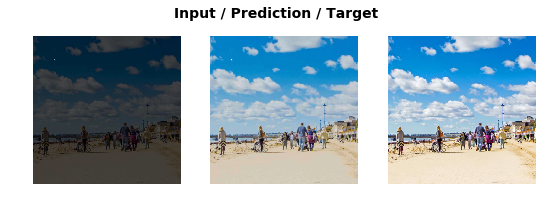

In [54]:
#fit whole model on high res data
do_fit('light_model_full',slice(1e-4,1e-2),cycles=8)

In [0]:
#For higher res images implement accumulating gradients (not done yet)

In [55]:
#destroy learner object
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [56]:
#make sure learner is empty and free up as much memeory as possible
learn = None
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
#recreate new learner
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)

In [0]:
#load model trained on high res data
learn.load(model_path/'light_model_full');

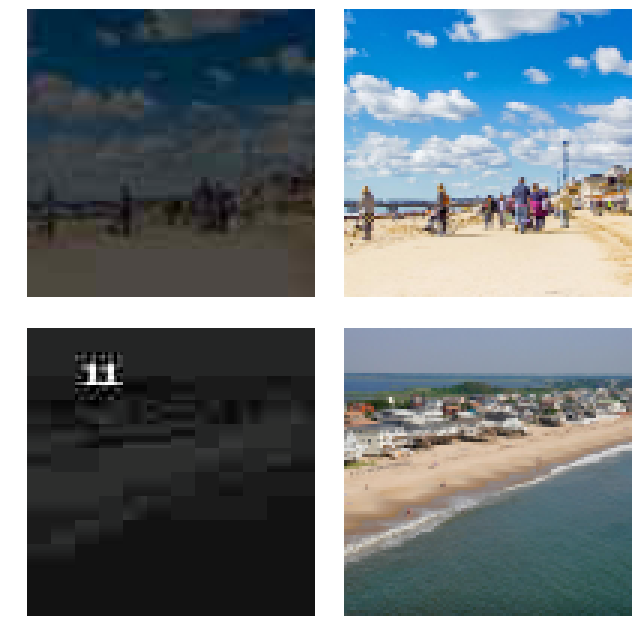

In [59]:
#initialize highest res images and show some
size = 1200
bs=1
data_hr = (ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(max_zoom=2),size = size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_hr.c = 3
learn.data = data_hr
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [0]:
#load highest res data
learn.data = data_hr

In [0]:
#try to free some memory
torch.cuda.empty_cache()

In [62]:
gc.collect()

7055

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


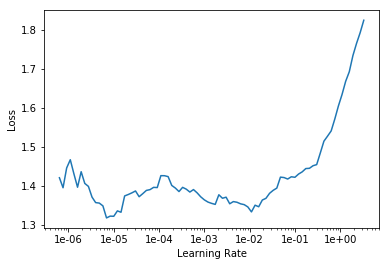

In [63]:
#find learning rate
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.429057,1.291441,0.347278,0.207143,0.196749,0.034048,0.309209,0.179480,0.017534,39:14
1,1.425221,1.291111,0.347083,0.207142,0.196753,0.034052,0.309109,0.179440,0.017533,39:16


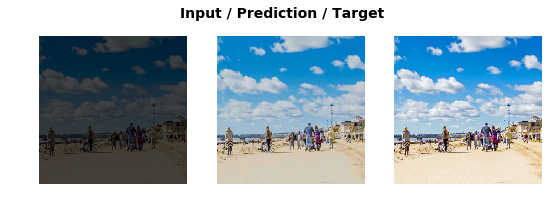

In [64]:
##fit last layers on highest res data
do_fit('light_model_highest', slice(1e-5),cycles=2)

In [65]:
#export model
learn.export(model_path/'light_model_export') 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
learn.unfreeze()

In [0]:
torch.cuda.empty_cache()


In [0]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


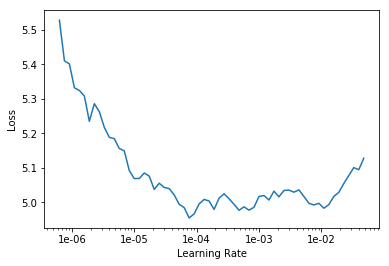

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.012326,0.014594,13:09
1,0.011933,0.014583,13:08
2,0.013097,0.014545,13:08
3,0.012067,0.014493,13:08
4,0.013262,0.014422,13:08
5,0.012133,0.014378,13:08
6,0.012839,0.014257,13:07
7,0.012540,0.014206,13:08
8,0.012812,0.014139,13:08
9,0.012932,0.014099,13:08


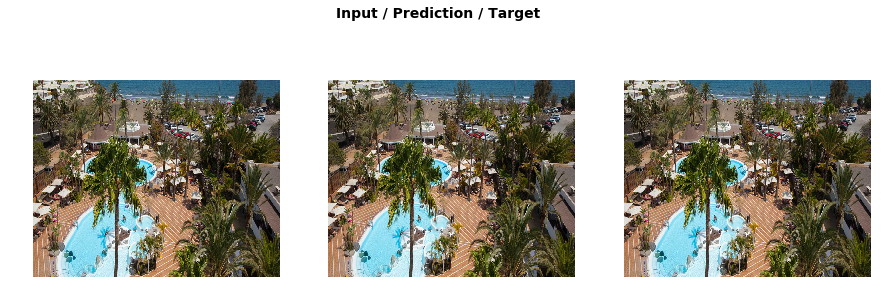

In [0]:
do_fit('4b',slice(1e-6,7e-4),cycles=6 )

In [0]:
files.download('./train/low_res/models/4b.pth') 

In [0]:
learn.freeze()

In [0]:
#run test interference with one image to see how well model is doing

In [0]:
learn = load_learner(learn.path)

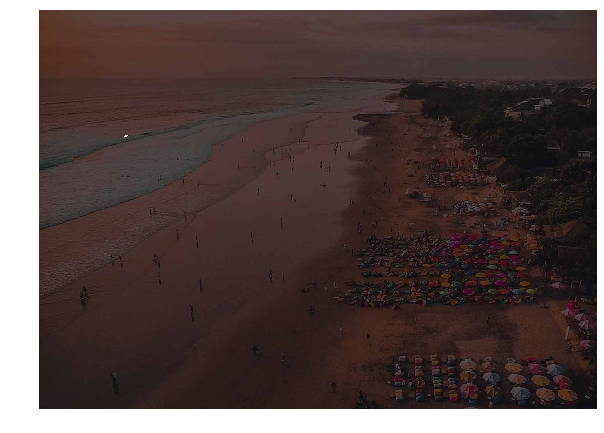

In [164]:
fn = data_hr.valid_ds.x.items[52]; fn
img = open_image(fn); img.shape
img.show(figsize=(10,10))


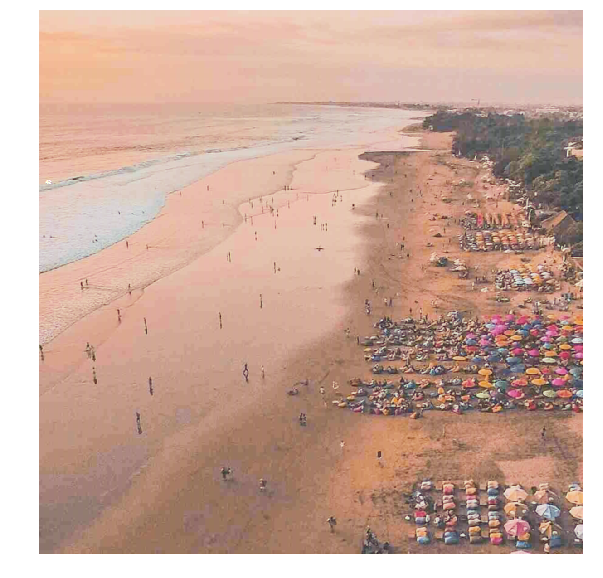

In [165]:
img.show(y=learn.predict(img)[0], figsize=(10,10))